
# Alpha Research Notebook – Backtesting Framework

This notebook builds a **modular backtesting framework** for evaluating different alpha signals on a universe of assets.  
The example signals used here are common in quantitative research: **momentum**, **volatility**, and **mean reversion**. The goals are to:

* generate sample data (here we use synthetic data for illustration);  
* construct generic functions for signal generation and performance calculation;  
* measure risk‑adjusted performance (Sharpe ratio, drawdown, etc.) and turnover;  
* compare multiple strategies in a standardised way.

> **Note:** The methodology is independent of the data source. In a professional environment you would use real market data (e.g. Fama/French factors, indices, individual stocks). The online data library run by Professor Kenneth French provides, for example, Fama–French factors in CSV format and other research portfolios, although accessing the files may require specific permissions.  
Here we generate synthetic price series to demonstrate how the framework works.



## 1. Environment setup

We start by importing the necessary libraries.  
We then define several utility functions:

- `generate_synthetic_prices`: generates simulated prices for a number of assets using a geometric Brownian motion process with specified drift and volatility.
- `compute_returns`: computes daily log returns from prices.
- `max_drawdown`: computes the maximum drawdown of a portfolio.
- `portfolio_metrics`: computes key performance statistics: annualised return, annualised volatility, Sharpe ratio, max drawdown and average turnover (after transaction costs).
- `backtest_cross_sectional`: backtests a cross‑sectional strategy based on a signal (ranking of assets). A balanced long/short portfolio is formed (long the assets with the highest signals and short those with the lowest signals).

All these functions are reusable and independent of the signal: you simply need to supply a DataFrame of signals with the same index (dates) and columns (assets) as the prices.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict

# Style parameters for the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Function to generate synthetic price series via a geometric Brownian motion

def generate_synthetic_prices(start_date: str, end_date: str, n_assets: int,
                              drift: np.ndarray, vol: np.ndarray, seed: int = 42) -> pd.DataFrame:
    # Generate synthetic prices for n_assets assets between start_date and end_date.
    # Prices follow a geometric Brownian motion with specified drift and volatility.
    np.random.seed(seed)
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    n_days = len(dates)
    dt = 1/252  # time step (252 trading days per year)

    # Standard normal random draws
    rand = np.random.standard_normal((n_days, n_assets))

    # Daily returns per asset
    daily_returns = (drift - (vol ** 2) / 2) * dt + vol * np.sqrt(dt) * rand

    # Initialise prices (start at 1)
    prices = np.ones((n_days, n_assets))
    for t in range(1, n_days):
        prices[t] = prices[t-1] * np.exp(daily_returns[t])

    columns = [f"Asset_{i+1}" for i in range(n_assets)]
    prices_df = pd.DataFrame(prices, index=dates, columns=columns)
    return prices_df

# Function to compute log returns
def compute_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices / prices.shift(1)).dropna()

# Function to compute maximum drawdown
def max_drawdown(cum_returns: pd.Series) -> float:
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

# Function to compute portfolio performance metrics
def portfolio_metrics(portfolio_returns: pd.Series, turnover: pd.Series, cost: float = 0.0005) -> Dict[str, float]:
    # Adjust returns for transaction costs
    net_returns = portfolio_returns - cost * turnover

    # Total and annualised return
    cum_return = (1 + net_returns).prod() - 1
    years = len(net_returns) / 252
    annual_return = (1 + cum_return) ** (1 / years) - 1

    # Annualised volatility
    annual_vol = net_returns.std() * np.sqrt(252)

    # Sharpe ratio (assume zero risk‑free rate)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan

    # Maximum drawdown
    cumulative = (1 + net_returns).cumprod()
    mdd = max_drawdown(cumulative)

    # Average turnover
    avg_turnover = turnover.mean()

    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': mdd,
        'Average Turnover': avg_turnover
    }

# Function to backtest a cross‑sectional strategy
def backtest_cross_sectional(prices: pd.DataFrame, signal: pd.DataFrame, quantile: float = 0.2,
                             cost: float = 0.0005) -> Tuple[pd.Series, Dict[str, float]]:
    # Align common dates
    common_idx = prices.index.intersection(signal.index)
    prices = prices.loc[common_idx]
    signal = signal.loc[common_idx]

    # Asset returns
    asset_returns = compute_returns(prices)
    signal = signal.loc[asset_returns.index]

    n_assets = asset_returns.shape[1]
    weights = pd.DataFrame(0, index=asset_returns.index, columns=asset_returns.columns)

    for date in asset_returns.index:
        sig_today = signal.loc[date].dropna()
        if len(sig_today) < 2:
            continue
        # Rank signals between 0 and 1
        ranked = sig_today.rank(method='first') / len(sig_today)

        # Select long and short assets
        long_assets = ranked[ranked > 1 - quantile].index
        short_assets = ranked[ranked < quantile].index
        n_long = len(long_assets)
        n_short = len(short_assets)
        if n_long + n_short == 0:
            continue
        # Equal weights: +0.5 across longs, −0.5 across shorts
        w = pd.Series(0, index=sig_today.index)
        if n_long > 0:
            w.loc[long_assets] = 0.5 / n_long
        if n_short > 0:
            w.loc[short_assets] = -0.5 / n_short
        weights.loc[date, w.index] = w

    # Propagate positions and fill missing values
    weights = weights.fillna(method='ffill').fillna(0)

    # Daily turnover
    turnover = weights.diff().abs().sum(axis=1)

    # Portfolio returns (lagged positions to avoid look‑ahead)
    portfolio_returns = (weights.shift(1) * asset_returns).sum(axis=1)

    metrics = portfolio_metrics(portfolio_returns, turnover, cost)

    return portfolio_returns, metrics



## 2. Generating synthetic data

To illustrate the methodology, we simulate **five assets** over the period 2020–2024 (business days).  
Each asset follows a geometric Brownian motion with an annual drift and volatility set arbitrarily to create different behaviours:

| Asset | Annual drift | Annual volatility |
|-----:|-------------:|------------------:|
| Asset_1 | 8 % | 15 % |
| Asset_2 | 12 % | 20 % |
| Asset_3 | 5 % | 10 % |
| Asset_4 | 10 % | 25 % |
| Asset_5 | 7 % | 18 % |

These values yield heterogeneous price series; in a real framework you would, of course, use genuine market data.


In [2]:

# Simulation parameters
drift_values = np.array([0.08, 0.12, 0.05, 0.10, 0.07])
vol_values   = np.array([0.15, 0.20, 0.10, 0.25, 0.18])

# Generate synthetic prices
prices = generate_synthetic_prices('2020-01-01', '2024-12-31', 5, drift_values, vol_values)

# Show the first few rows
display(prices.head())


,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5
2020-01-01,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-02,0.998062,1.020500,1.005026,0.992905,1.006386
2020-01-03,0.993973,1.014933,1.006738,0.963696,0.987104
2020-01-06,0.988975,1.002462,1.008913,0.950273,0.971630
2020-01-07,1.003041,1.000011,1.009523,0.929442,0.965857



## 3. Constructing alpha signals

We define three classic signals:

1. **Momentum**: the return over a 20‑day lookback window (around one month).  
2. **Inverse volatility**: the negative of the standard deviation of daily log returns over a 20‑day window; a high value indicates low volatility and therefore a long position.
3. **Mean reversion**: a z‑score computed by subtracting the 20‑day moving average from the price and dividing by the standard deviation; a negative score (price below its mean) is interpreted as a buy signal.

The functions below return DataFrames aligned with the price data.


In [3]:

# Signal functions
def momentum_signal(prices: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    return prices.pct_change(window).dropna()

def volatility_inverse_signal(prices: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    returns = compute_returns(prices)
    vol = returns.rolling(window).std()
    return -vol

def mean_reversion_signal(prices: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    mean = prices.rolling(window).mean()
    std  = prices.rolling(window).std()
    z_score = (prices - mean) / std
    return -z_score

# Compute signals
a_signal = momentum_signal(prices)
b_signal = volatility_inverse_signal(prices)
c_signal = mean_reversion_signal(prices)

# Align signals on a common date range
first_date = max(a_signal.index[0], b_signal.index[0], c_signal.index[0])
a_signal = a_signal.loc[first_date:]
b_signal = b_signal.loc[first_date:]
c_signal = c_signal.loc[first_date:]

# Inspect the first rows of each signal
display(a_signal.head())
display(b_signal.head())
display(c_signal.head())


,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5
2020-01-29,-0.010315,0.043575,0.005694,-0.114495,-0.094893
2020-01-30,-0.004328,0.047619,0.001945,-0.104298,-0.101203
2020-01-31,-0.017927,0.053432,0.000798,-0.040385,-0.085448
2020-02-03,-0.009878,0.066494,-0.008507,-0.008886,-0.062727
2020-02-04,-0.016170,0.057348,-0.000132,-0.008529,-0.050627


,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5
2020-01-29,-0.008060,-0.010769,-0.004944,-0.012894,-0.012341
2020-01-30,-0.008117,-0.011141,-0.004825,-0.013098,-0.012099
2020-01-31,-0.008998,-0.011005,-0.004812,-0.015245,-0.011656
2020-02-03,-0.008986,-0.010454,-0.005043,-0.015617,-0.011692
2020-02-04,-0.008542,-0.010869,-0.005467,-0.015590,-0.011885


,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5
2020-01-29,1.111689,-1.711546,-0.215643,0.874036,1.435156
2020-01-30,0.712075,-2.473824,-0.447073,0.744894,1.360359
2020-01-31,1.992780,-2.056870,-0.547036,-1.201360,1.298484
2020-02-03,1.617984,-1.766997,0.776237,-2.340266,0.923058
2020-02-04,0.945925,-1.191664,-0.995144,-1.175361,0.624265



## 4. Backtesting the strategies

Each signal is now backtested using `backtest_cross_sectional`.  
Parameters used:

- **quantile = 0.2**: the top 20 % of assets (by signal) are bought and the bottom 20 % are sold.
- **cost = 0.0005** (i.e. 5 basis points): transaction cost applied to daily turnover.

We obtain the daily portfolio returns and a set of metrics for each strategy. Cumulative performance is plotted below.


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/tmp/ipython-input-263807409.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w.loc[long_assets] = 0.5 / n_long
/tmp/ipython-input-263807409.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w.loc[long_assets] = 0.5 / n_long
/tmp/ipython-input-263807409.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w.loc[long_assets] = 0.5 / n_long
/tmp/ipython-input-263807409.py:108: Fut

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Average Turnover
Momentum,-0.022464,0.097470,-0.230466,-0.353964,0.212617
InverseVolatility,0.003276,0.053034,0.061767,-0.112101,0.028037
MeanReversion,-0.051920,0.091329,-0.568492,-0.291149,0.284268


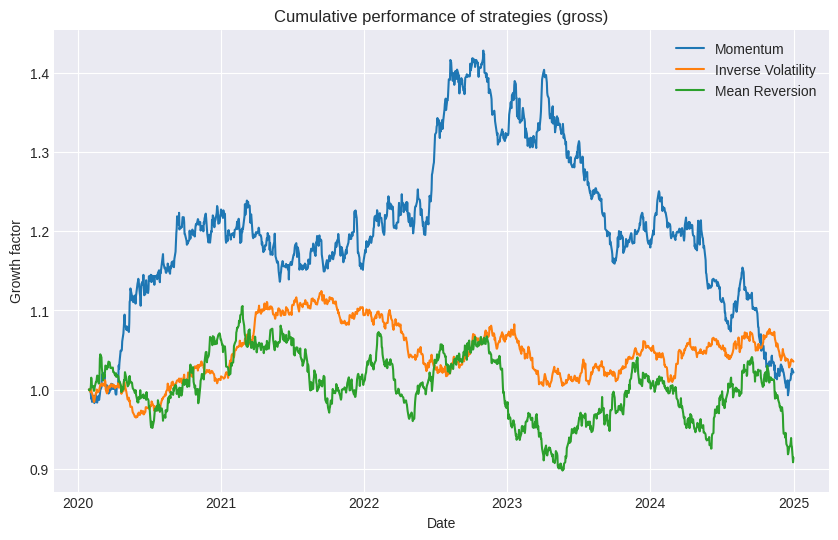

In [4]:

# Backtest parameters
quantile = 0.2
cost     = 0.0005

# Backtest each signal
returns_mom, metrics_mom = backtest_cross_sectional(prices, a_signal, quantile, cost)
returns_vol, metrics_vol = backtest_cross_sectional(prices, b_signal, quantile, cost)
returns_mr,  metrics_mr  = backtest_cross_sectional(prices, c_signal, quantile, cost)

# Consolidate metrics
metrics_df = pd.DataFrame({
    'Momentum': metrics_mom,
    'InverseVolatility': metrics_vol,
    'MeanReversion': metrics_mr
}).T

# Display metrics
display(metrics_df)

# Cumulative performance (plotted without re‑applying costs)
cum_mom = (1 + returns_mom).cumprod()
cum_vol = (1 + returns_vol).cumprod()
cum_mr  = (1 + returns_mr).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_mom.index, cum_mom, label='Momentum')
plt.plot(cum_vol.index, cum_vol, label='Inverse Volatility')
plt.plot(cum_mr.index,  cum_mr,  label='Mean Reversion')
plt.title('Cumulative performance of strategies (gross)')
plt.xlabel('Date')
plt.ylabel('Growth factor')
plt.legend()
plt.show()



## 5. Comparative analysis

We compare the strategies by looking at their metrics and the correlation of their daily returns. Low correlation suggests diversification potential when combining multiple signals.


In [5]:

# DataFrame of daily returns
returns_df = pd.DataFrame({
    'Momentum': returns_mom,
    'InverseVolatility': returns_vol,
    'MeanReversion': returns_mr
}).dropna()

# Correlation matrix
corr_matrix = returns_df.corr()

display(corr_matrix)

display(metrics_df)


,Momentum,InverseVolatility,MeanReversion
Momentum,1.000000,0.083058,0.010402
InverseVolatility,0.083058,1.000000,0.129007
MeanReversion,0.010402,0.129007,1.000000


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Average Turnover
Momentum,-0.022464,0.097470,-0.230466,-0.353964,0.212617
InverseVolatility,0.003276,0.053034,0.061767,-0.112101,0.028037
MeanReversion,-0.051920,0.091329,-0.568492,-0.291149,0.284268



## 6. Conclusion and perspectives

This notebook demonstrates the construction of a **modular backtesting framework**. Key points:

- **Modular signals:** each type of signal is coded as a standalone function. New signals (macro, sentiment, implied volatility, etc.) can easily be added.
- **Generic backtest:** the backtesting function automatically applies a balanced long/short strategy and computes turnover to account for transaction costs.
- **Professional performance measures:** annualised return, volatility, Sharpe ratio, maximum drawdown and average turnover, which are essential indicators for PMs and QIS teams.

In practice, this framework would be applied to high‑quality historical market data (for example those available from Kenneth French’s data library) and could be enriched by imposing neutrality constraints (sector, beta) and evaluating additional signals (macro factors, NLP sentiment, etc.).

This approach allows you to quickly experiment with different strategies and assess their robustness before potentially integrating them into an investment process.
